# Executive Summary

1.  Across all available metrics of success, Spotify-created playlists are much more successful than nearly all user-created playlists.

2.  We consider nine metrics of playlist success, including measures of total streams and total users over the past day, week, month and two months.  Amongst both the user-created and Spotify-created playlists, these measures of success are very highly correlated with one another, thus suggesting any choice of these success metrics would likely be sufficient.

3.  Spotify-created playlists tend to have fewer total tracks while exhibiting fairly similar music diversity per track, as measured by tracks per artist and trackers per album.

4.  The distribution of most common genre and mood are fairly similar across Spotify-created and user-created playlists.  Some of the most common primary genres are Indie Rock, Rap and Pop, while some of the most common primary moods are 'defiant', 'excited' and 'yearning'.

5.  For purposes of understanding what predicts playlist success, we consider two outcomes: (1) number of users who had at least stream of greater than 30 seconds today, and (2) the number of users who had at least one stream of greater than 30 seconds in the current month and the previous month.  The former outcome provides a measure of short-term success, while the latter provides a better measure of longer-term playlist staying power.  

6.  Across both outcomes and Spotify-created and user-created playlists, the number of tracks is the most important predictor of success, with longer playlists tending to be more successful.

7.  For Spotify-created playlists, having greater musical diversity (as measured by tracks per album and tracks per artist) is associated with increased success.  This effect is present for the user-created playlists, but is less pronounced.

8.  Greater musical diversity is more important for a playlist's long-term staying power than for short-term success, with one of the musical diversity metrics being the second most important predictor (behind total tracks) for the long-term success metric.

9.  For Spotify-created playlists, the primary moods that are most associated with both measures of success are 'defiant', 'excited', 'melancholy', 'sensual', and 'upbeat'.  For user-created playlists, 'defiant', 'excited' and 'upbeat' were also associated with increased success, however 'melancholy' is associated with decrease short-term success.

10.  For Spotify-created playlists, the primary genres of 'dance & house' and 'pop' are associated with both short-term and long-term success.  "Indie Hood", 'Jazz' and 'R & B' increase short-term success, while 'alternative' and 'rap' increase long-term success.

11.  The most success-inducing primary genres for Spotify-created and user-created vary considerably.  For user-created playlists, "Children's", "Latin" and "Traditional" increase both short- and long-term success.

In [7]:
%%capture
# Game Plan:
# 1. Show that the choice of outcome variable does not matter very much because of the extremely high correlation between potential outcomes.
#     - Create a nice looking correlation plot for the outcomes
#     -  Probably try to create the sns.pairplot() although that function was very very slow
# 2.  Point out that the Spotify playlists are MUCH more successful than the typical user playlist
#     - Can show that by plotting bar charts next to each other, group by whether owner == "spotify"
# 3.  Have to make a decision on what outcome variable to choose (or most likely a combination of outcome variables!)
# 4.  Look at univariate cuts of the outcome variable(s) with the predictors, just to try to give a sense of the relationship between the variables prior to modeling
# 5.  Build a baseline model that we can use for prediction and then we can compare this to a more advanced model -- will allow for simpler interpretations
# 6.  Build an ML model that we can then go compare efficacy with the baseline model.

# Note: 
# 1.  We will likely want to run separate analyses broken out by owner == 'spotify' vs owner != 'spotify'
#     a.  See if the importance of the other predictors is comparable for the two groups
# 2.  If a user streams 2 or more songs consecutively, does that count as 2 streams or only 1 since the stream were consecutive? 


# Possible Options (no particular order)
# 1.  Look into multivariate methods to accommodate the various potential outcome variables (or could just pick one/create a PCA)
# 2.  Should probably think through how to use the 'skippers' data.  Could this be at all helpful in dealing with potential biases in how Spotify may promote playlists? 

Assumptions:
1.  This is a random sample of playlists.  If this a biased sample, then any generalizations that we make from the data is likely to be meaningfully inaccurate.

2.  Spotify treats each non-Spotify playlist equally in terms of promotion.  For examples, if the Spotify algorithms were promoting some genres above others at the time this data was collected, then we are unlikely to get a good read on how genre affects listenership.  

3.  
    (a) Spotify treats its own playlists differently than the non-Spotify playlists.  If this assumption is correct, then it is likely that Spotify playlists are not particularly comparable to non-Spotify playlists.  
    (b) Spotify treats its own playlists equally with each other.  Thus, an analysis with only Spotify playlists should be okay.  
    
4.  Each playlist included in the dataset has existed for at least two months.  This ensures that the monthly average users in the previous month variable is not biased by how long the playlist has existed.

5.  The Spotify algorithms do not amplify small variations in success.  If playlist A was slightly more successful than Playlist B two months ago under 'fair' algorithmic treatment, then the algorithms will not amplify playlist A over playlist B, and thus widen the gulf between the success of the two playlists.  In other words, there is a fair marketplace for the playlists to compete, where success does not necessarily beget success simply due to the algorithms.

6.  For the categorical variables, genre_1-genre_3 and mood_1-mood_3, when the value is '-' this is not a missing value, but is instead imparting the information that the given playlist does not easily fit into the predefined genre and mood types. 

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.model_selection import KFold
import shap
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [9]:
outcome_vars_dict = {'streams': 'streams_today_any', 
                    'stream30s': 'streams_today_30s',
                    'monthly_stream30s': 'streams_month_30s',                  
                    'dau': 'users_today_30s', 
                    'wau': 'users_week_30s', 
                    'mau': 'users_month_30s', 
                     'users': 'users_month_any',
                    'mau_previous_month': 'users_previousmonth_30s',
                    'mau_both_months': 'users_bothmonths_30s',
               }

outcome_vars = list(outcome_vars_dict.values())


raw_data = pd.read_table('data/playlist_summary_external.txt')
raw_data = raw_data.rename(columns = outcome_vars_dict)
spotify_data = raw_data.query('owner == "spotify"')
nonspotify_data = raw_data.query('owner != "spotify"')
# outcome_vars = ['streams', 
#                 'stream30s', 
#                 'dau', 
#                 'wau', 
#                 'mau', 
#                 'mau_previous_month',
#                 'mau_both_months',
#                 'users',
#                 'monthly_stream30s',
#                ]




predictor_vars = ['n_tracks', 
                 'n_local_tracks',
                  'n_artists',
                  'n_albums',
                  'genre_1',
                  'genre_2',
                  'genre_3',
                  'mood_1',
                  'mood_2',
                  'mood_3'
                 ]

# Introduction

The data under consideration for these analyses consists of 403,366 distinct playlists, with 314,899 distinct playlist owners.  Of the 314,899 unique playlist owners, 261,040 (83%) have exactly one playlist in the data.  Of the owners with more than one playlist, Spotify itself has the most, with 399.  The data is composed of only playlists from US owners, and thus extrapolating any of these analyses to other countries is likely unwarranted or should be done with great caution.  Each playlist is categorized by its top three genres and top three moods.  There are 26 genres and 27 moods under consideration.

There are a number of potential measures of playlist success included in this dataset.  Specifically, we have (1) the number of streams of any length from the playlist today, (2) the number of streams greater than 30 seconds today, (3) the number of active users today, where an active user is defined as having a stream $>30$ seconds, (4) the number of active users in the past week, (5) the number of active users in the past month, (6) the number of users who had a stream from this playlist for any length of time in the past month, (7) the number of active users in the previous month, (8) the total number of $>30$ second streams in the past month, (9) the number of users who were active this month and the previous month.  The data also contains a variable signifying the number of $>30$ second streams by the playlist owner in the past month, but this analysis will focus on broader measures of success, and thus we will not analyze this variable.  Finally, the data also includes the number of users who skipped more than 90% of their total streams today who also used this playlist.  This variable does not directly measure the proportion of skips for each playlist, but instead measures simply whether users who skip often listen to this playlist.  Thus variable will thus also not be included in these analyses.   

Some of the potential predictors of stream success include: (1) the number of tracks in the playlist, (2) the number of tracks that were added to the playlist today, (3) The number of unique artists in the playlist, (4) the number of unique albums in the playlist, (5-7) the first, second and third most common genre found in the playlist, (8-10) the first, second and third most common mood found in the playlist.  While number of tracks, artists and albums are each measures of playlist size, the most direct measure is number of tracks, so we will thus use it directly in the analyses.  We will use number of tracks per artist and number of tracks per album as inverse measures of musical diversity.  The dataset also contains unstructured tokens associated with each playlist.  Due to the time constraints for these analyses and the unstructured nature of the data, these tokens will not be considered in the analyses.  

The analyses will be structured as follows.  

1.  We will first explore the massive differences in playlist success between the Spotify-created and user-created playlists.  

2.  The substantial correlation between each of the measures of success across both Spotify-created and user-created playlists will next be discussed.  A principal components analysis and factor analysis will be performed.

3.  We next present the distribution of the predictors of success, including both the numeric (number of tracks, tracks per artist and tracks per album) as well as the categorical (the mood and genre variables).

4.  We finally fit gradient boosting models to predict measures of both short-term and long-term success, stratifying by Spotify-created and user-created playlists.  Because we are interested primarily in understanding the factors affecting success, we use SHAP values to measure the most important predictors, as well as whether the predictors are postively or inversely related to success.  For the categorical mood and genre predictors, we will present SHAP values for each level of the variable.

# Comparing Spotify-Created and User-Created Playlists

There are two Spotify-created playlists that constitute extreme outliers across each of the potential outcome variables.  The first is a pop, Dance & House, Indie Rock playlist with 100 tracks and has tokens 'top', 'tracks', 'currently', 'spotify'.  The second is a pop, R&B, Dance & House with 51 tracks and has tokens 'top', and 'hits'.  These two playlists have more than three times as many streams today as their nearest competitor and more than four times as many $>30$ second streams in the past month as the nearest competitor.  For the purposes of plotting, these playlists will be removed.


Even after removing the two most successful Spotify-created playlists, there is still a wide gulf between the Spotify-created and user-created playlists.  To illustrate this, consider the boxen plot below, which shows the distribution of each of the potential outcome variables stratified by whether the playlist is creator type.  We observe that the Spotify-created playlists are much more successful than the vast majority of user-created playlists.  However, there are a few user-created playlists that can rival an average Spotify-created playlist.  

In [10]:
raw_data['spotify_created'] = raw_data['owner'] == 'spotify'
comparison_data = (raw_data.
                   drop(index = [163726, 152032]).
                   loc[:, ['spotify_created'] + outcome_vars].
                   melt(id_vars = 'spotify_created',
                       var_name = 'outcome',
                       value_name = 'value')
                  )

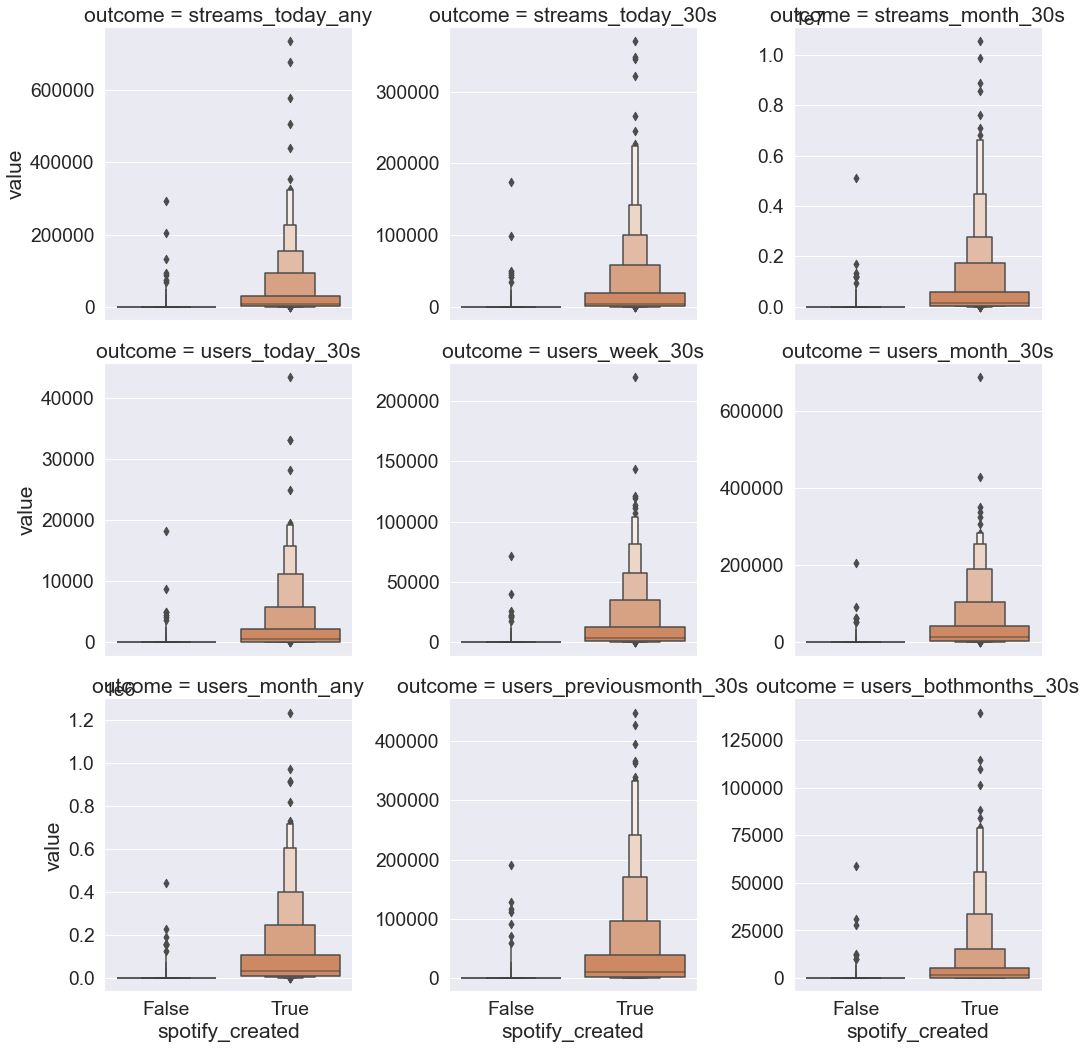

In [11]:
sns.set(font_scale = 1.75)
p = sns.catplot(data = comparison_data,
            kind = 'boxen',
            col = 'outcome',
            col_wrap = 3,
            sharey = False,
            y = 'value', 
            x = 'spotify_created')

#p.fig.suptitle('Distribution of Various Measures of Playlist Success Stratified by Creator Type')

# Exploration of Potential Outcomes

Because there is such an enormous difference between Spotify-created and user-created playlists, we will continue our data exploration stratifying by whether the playlist is Spotify-created.

To begin understanding the relationship between the potential outcomes of interest, we present a heatmap of the Pearson correlation between each of the outcomes.  We create one such heatmap for the user-created playlists and another for the Spotify-created playlists.  Amongst the user-created playlists, we see that the minimum correlation between any of the outcomes is 0.78, thus signifying a great deal of correlation between our potential outcomes.  While all potential outcomes are highly correlated, the mostly weakly correlated outcomes are the outcomes related to playlists' longer-term success (i.e. the monthly average users in the given month and the previous month) with the more recent measures of success (i.e. the number of total and >30 second streams today and the number of active users today and in the past week).  Amongst the Spotify-created playlists, the potential outcomes are even more highly correlated, with the smallest correlation being 0.91.  The Spotify-created playlists exhibit a similar general pattern as the user-created in that the weakest correlation between the outcomes is between the more long-term measures of success and the measures of success in the more recent past.  However, the degree of correlation is still immense between monthly active users over the past two months and the number of streams that occurred today, thus indicating that Spotify playlists tend to have considerable 'staying power'.  Of course, if more successful playlists in the past are algorithmically pushed to users, then this could become a self-fulfilling prophecy rather than a true indication of how 'intrinsically good' the playlist is.  

In [12]:
def plot_outcome_corr(data):
    plot_data = data.loc[:, outcome_vars]
    plot_data_corr = plot_data.corr()
    return plot_data, sns.heatmap(plot_data_corr, annot = True, cmap = 'BrBG')

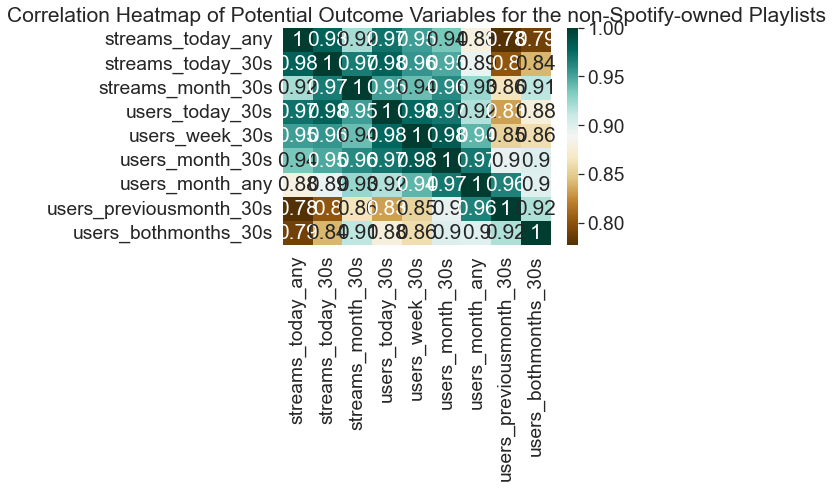

In [7]:
#%%capture
nonspotify_outcome_data, nonspotify_heatmap = plot_outcome_corr(nonspotify_data)
nonspotify_heatmap.set_title('Correlation Heatmap of Potential Outcome Variables for the non-Spotify-owned Playlists');

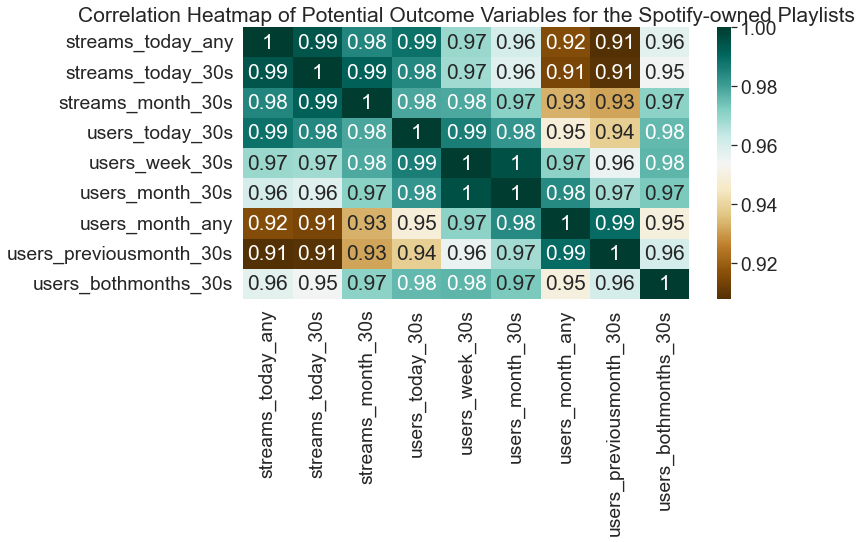

In [42]:
spotify_outcome_data, spotify_heatmap = plot_outcome_corr(spotify_data)
spotify_heatmap.set_title('Correlation Heatmap of Potential Outcome Variables for the Spotify-owned Playlists');

## Principal Components Analysis of Potential Outcomes

We will continue our exploration of the relationship between the potential outcomes by performing a factor analysis.  We observed that the correlation matrix for both the Spotify-created and user-created playlists is quite high.  We would thus next like to address the question of to what degree can this information be reduced to one or a few factors, i.e. how much of the information encoded in these 9 potential outcomes is redundant.  To help answer this question, we will employ a principal components analysis (PCA) on the user-created outcomes data.  The results for the Spotify-created outcomes data are similar and can be found in the Appendix.  

From the plot below, we see that the first principal component explains approximately 92% of the variation across the 9 potential outcomes, thus indicating that there is a great deal of redundancy in these measured outcomes.  The second principal component explains another approximately 5% of variance. We can thus explain 97% of the variability of the 9 outcomes with 2 numbers (or components). 

In [180]:
nonspotify_outcome_scaled = StandardScaler().fit_transform(nonspotify_outcome_data)
spotify_outcome_scaled = StandardScaler().fit_transform(spotify_outcome_data)

In [188]:
def plot_percent_variation_explained(data, title):
    pca = PCA(n_components = data.shape[1])
    pca.fit(data)
    percent_explained = 100 * pca.explained_variance_ratio_.cumsum()
    percent_explained = np.insert(percent_explained, obj = 0, values = 0.0, axis = 0)
    plt.plot(percent_explained)
    plt.title(title,
             fontdict = {'fontsize': 16})
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Percent Variance Explained');
   

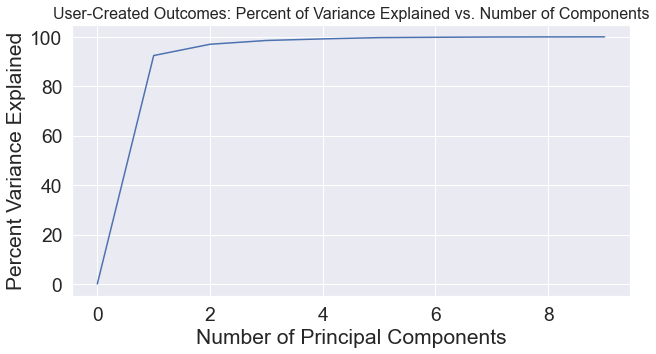

In [189]:
 plot_percent_variation_explained(
     nonspotify_outcome_scaled,
     title = 'User-Created Outcomes: Percent of Variance Explained vs. Number of Components'
 )

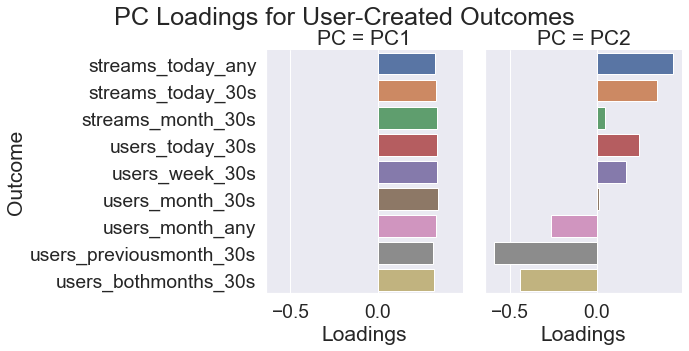

In [175]:
def plot_pca_loadings(data, title, n_components = 2):
    pca2 = PCA(n_components = n_components)
    pca2.fit(data)

    pca_df = (pd.DataFrame(pca_loadings.T,
                         columns = ['PC1', 'PC2'],
                         index = data.columns).
              reset_index().
              rename(columns = {'index': 'outcome'}).
              melt(id_vars = 'outcome',
                   value_vars = ['PC1', 'PC2'],
                   var_name = 'PC',
                       value_name = 'loading')
         )

    load_plot = sns.catplot(data = pca_df,
                kind = 'bar',
               y = 'outcome',
               x = 'loading',
               col = 'PC')   

    load_plot.set_ylabels('Outcome')
    load_plot.set_xlabels('Loadings')
    load_plot.fig.suptitle(title, y = 1)
    
plot_pca_loadings(nonspotify_outcome_data,
                 title = 'PC Loadings for User-Created Outcomes')

## Exploration of Predictors of Interest


In [192]:
predictor_data = raw_data.loc[:, ['spotify_created'] + predictor_vars]

Note that for the plots below, we drew a random sample of user-created playlists for these plots in order for them not to visually swamp the Spotify-created playlists.  We can see from the plot below that, unsurprisingly, as a playlist's number of tracks increases so do the number of artists and albums.  We will thus define tracks per artist and tracks per album as scaled measures of the number of artists and albums that account for the overall size of the playlist.  Also, note that the distribution of number of tracks, artists and albums does not vary between Spotify-created and user-created to the degree that the outcome variables do.  However, we still observe some difference between user-created and Spotify-created playlists, namely that user-created playlists tend to have moer tracks, artists and albums, with some user-created playlists having many more of each.

In [193]:
np.random.seed(2)
continuous_predictors = (predictor_data.
                         loc[:, ['spotify_created',
                                 'n_tracks', 
                                 #'n_local_tracks', 
                                 'n_artists', 
                                 'n_albums',]].
                         groupby('spotify_created').
                         # melt(var_name = 'predictor',
                         #     value_name = 'value').
                         sample(399)                       
                        )

# sns.pairplot(continuous_predictors,
#             hue = 'spotify_created')

In [194]:
predictor_data['tracks_per_artist'] = predictor_data.n_tracks / predictor_data.n_artists
predictor_data['tracks_per_album'] = predictor_data.n_tracks / predictor_data.n_albums

Let's consider the correlation of the new scaled measures of artists and albums as well as whether we observe differences between the user-created and Spotify-created playlists.  Notice that the distribution of tracks per artist and tracks per album appear quite similar for the user-created and Spotify-created playlists.  Spotify-created playlist appear to exhibit a little bit more artist and album diversity than the user-created playlists, but the difference is miniscule compared to the outcome variables.  

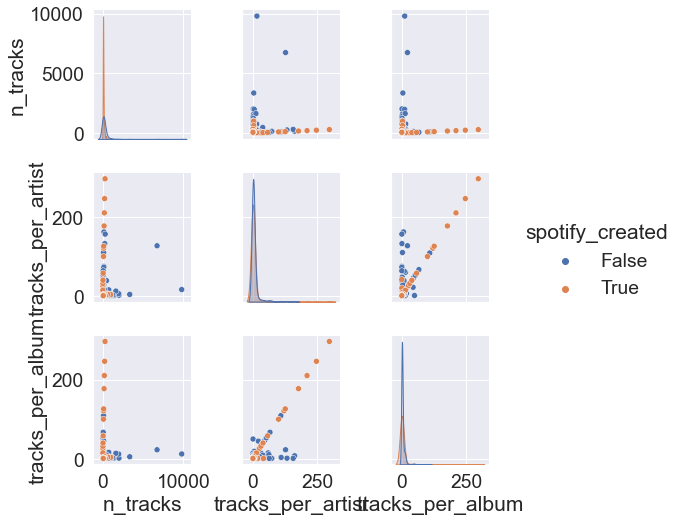

In [196]:
np.random.seed(2)
scaled_predictors = (predictor_data.
                         loc[:, ['spotify_created',
                                 'n_tracks', 
                                 #'n_local_tracks', 
                                 'tracks_per_artist', 
                                 'tracks_per_album',]].
                         groupby('spotify_created').
                         # melt(var_name = 'predictor',
                         #     value_name = 'value').
                         sample(399)                     
                        )

sns.pairplot(scaled_predictors,
            hue = 'spotify_created')

We now turn our attention to describing the categorical predictors: genre and mood.

In [17]:
cat_vars = ['genre_1',
            'genre_2',
            'genre_3',
            'mood_1',
            'mood_2',
            'mood_3'
            ]

cat_preds = (predictor_data.
             loc[:, ['spotify_created'] + cat_vars]
            )


In [18]:
def plot_cat_var(pred):

    cat_order = (cat_preds[pred].
                 value_counts().
                 reset_index().
                 rename(columns = {pred: 'count',
                                   'index': pred
                                  }).
                 sort_values('count', ascending = False)            
                )

    my_plot = sns.barplot(
        data = cat_order,
        y = pred,
        x = 'count'
    )

    my_plot.set_title(f'Distribution of {pred}')
    
    return my_plot



<AxesSubplot:title={'center':'Distribution of genre_1'}, xlabel='count', ylabel='genre_1'>

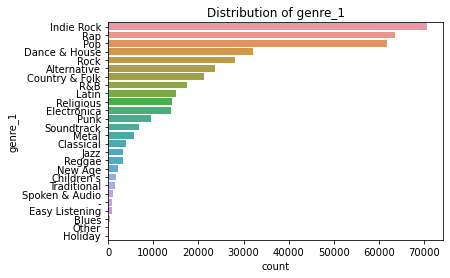

In [19]:
plot_cat_var('genre_1')

In [20]:
#plot_cat_var('genre_2')

In [21]:
#plot_cat_var('genre_3')

<AxesSubplot:title={'center':'Distribution of mood_1'}, xlabel='count', ylabel='mood_1'>

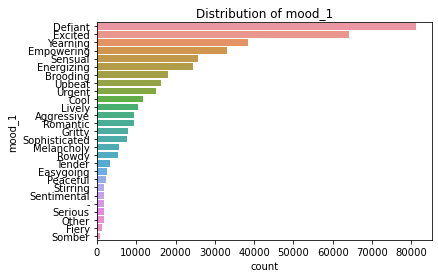

In [22]:
plot_cat_var('mood_1')

In [23]:
#plot_cat_var('mood_2')

In [24]:
#plot_cat_var('mood_3')

We now need to get a sklearn pipeline built for modeling the various outcomes.  We will try to predict the outcomes 'users_today_30s' and 'users_bothmonths_30s'.  We choose 'users_today_30s' because amongst the user-created playlists, it very highly correlated with streams_today_any, streams_today_30s, streams_month_30s, users_week_30s, and users_month_30s (with the minimum correlation being 0.95).  It is also less correlated with users_previousmonth_30s (0.83) and users_bothmonths_30s (0.88).  We choose 'users_bothmonths_30s' because (1) it is less corelated than many of the other outcomes and (2) it is a good measure of a playlist's longer-term staying power.

In [25]:
def fit_lgb_mod(X, y):

    lgb_data = lgb.Dataset(data = X,
                          label = y,
                          params = {'verbose': -1}
                          )

    lgb_params = {'learning_rate': 1.0,
              'objective': 'huber' # deal with outliers 
               }

    lgb_cv = lgb.cv(params = lgb_params,
                    train_set = lgb_data,
                    num_boost_round = 10000,
                    nfold = 10,
                    verbose_eval = -1, 
                    stratified = False,
                    early_stopping_rounds = 25,
                    return_cvbooster = True)

    lgb_booster = lgb_cv.get('cvbooster')
    n_trees = lgb_booster.best_iteration
    
    lgb_mod = lgb.train(params = lgb_params,
                       train_set = lgb_data,
                       num_boost_round = n_trees,
                       verbose_eval = -1)
    
    return lgb_mod




In [26]:
X = predictor_data.drop(columns = ['n_artists', 'n_albums'])
cat_columns = ['genre_1', 'genre_2', 'genre_3', 'mood_1', 'mood_2', 'mood_3']
for column in cat_columns:
    X[column] = X[column].astype('category')


In [27]:
# Get the modeling input data for the Spotify-only models and no-Spotify models
X_spotify = X.query('spotify_created == True').drop(columns = 'spotify_created')
users_today_spotify = raw_data.query('spotify_created == True').loc[:, 'users_today_30s']
users_bothmonths_spotify = raw_data.query('spotify_created == True').loc[:, 'users_bothmonths_30s']


# Get the modeling input data for the Spotify-only models and no-Spotify models
X_nonspotify = X.query('spotify_created == False').drop(columns = 'spotify_created')
users_today_nonspotify = raw_data.query('spotify_created == False').loc[:, 'users_today_30s']
users_bothmonths_nonspotify = raw_data.query('spotify_created == False').loc[:, 'users_bothmonths_30s']

In [28]:
%%capture
users_today_spotify_mod = fit_lgb_mod(X = X_spotify,
                                     y = users_today_spotify)

In [29]:
%%capture
users_bothmonths_spotify_mod = fit_lgb_mod(X = X_spotify,
                                           y = users_bothmonths_spotify)

In [30]:
def create_model_explanations(mod, 
                              X, 
                              n_samples = 20000, 
                              vars_plot_dependence = ['genre_1', 'mood_1']):

    n_samples = min(n_samples, len(X))
    explainer = shap.TreeExplainer(mod)
    X_reduced = X.sample(n_samples)
    shap_values = explainer.shap_values(X_reduced)
    
    # shap_summary = shap.summary_plot(
    #     np.delete(shap_values, obj = 0, axis = 1), 
    #     X_reduced.drop(columns = 'spotify_created'))
    
    shap_summary = shap.summary_plot(shap_values, X_reduced)
    
    plt.show(shap_summary)
    
    #top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))
    
    for var in vars_plot_dependence:
        shap.dependence_plot(var, shap_values, X_reduced)

# Modeling Results for Number of Users Today Amongst Spotify-Owned Playlists

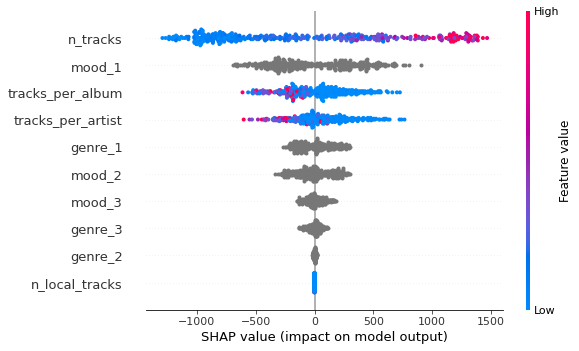

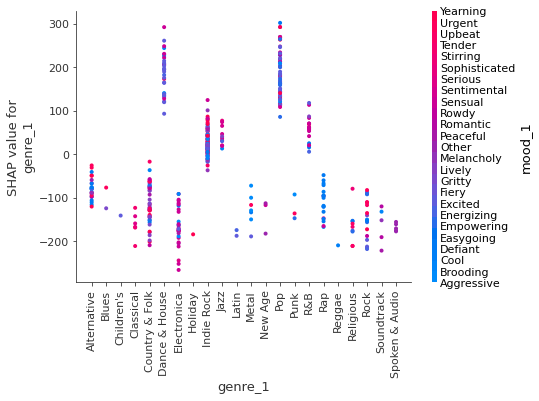

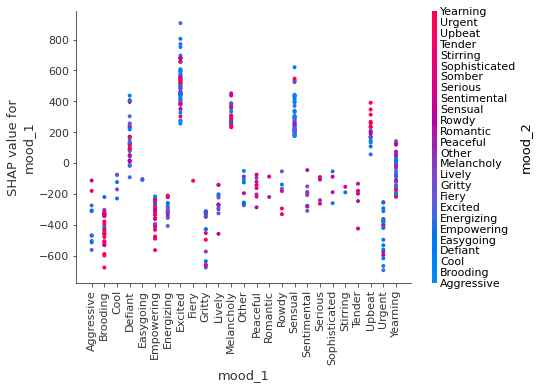

In [31]:
create_model_explanations(mod = users_today_spotify_mod,
                          X = X_spotify)

# Modeling Results for Number of Users in Current and Previous Month Amongst Spotify-Owned Playlists

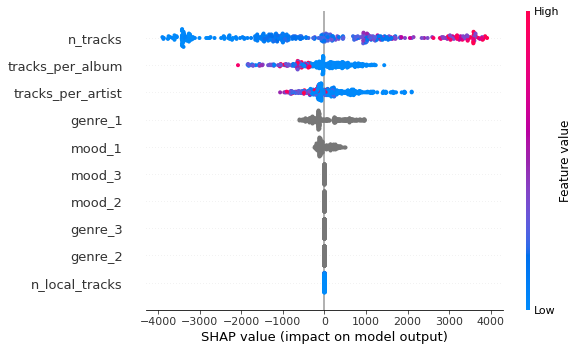

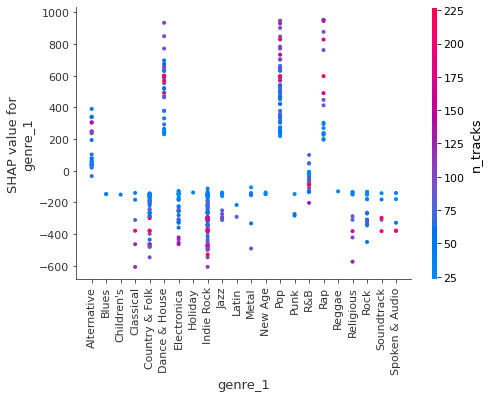

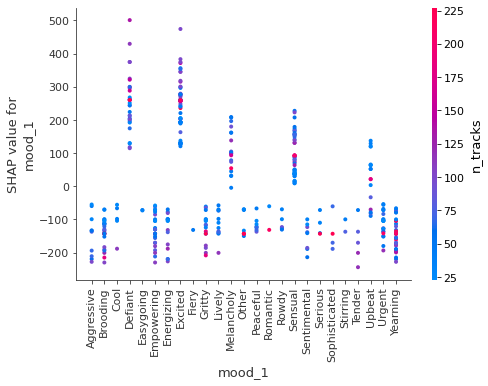

In [32]:
create_model_explanations(mod = users_bothmonths_spotify_mod,
                          X = X_spotify)

In [33]:
%%capture
users_today_nonspotify_mod = fit_lgb_mod(X = X_nonspotify,
                                     y = users_today_nonspotify)

In [34]:
%%capture
users_bothmonths_nonspotify_mod = fit_lgb_mod(X = X_nonspotify,
                                     y = users_bothmonths_nonspotify)

# Modeling Results for Number of Users Today Amongst User-Owned Playlists

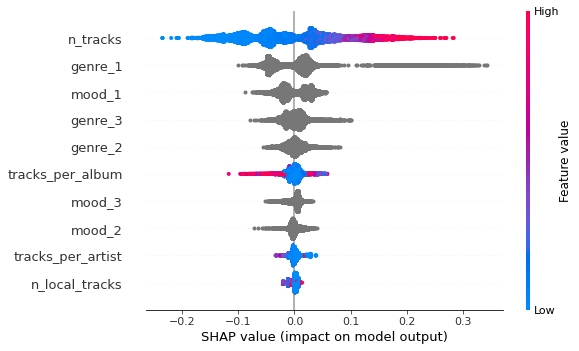

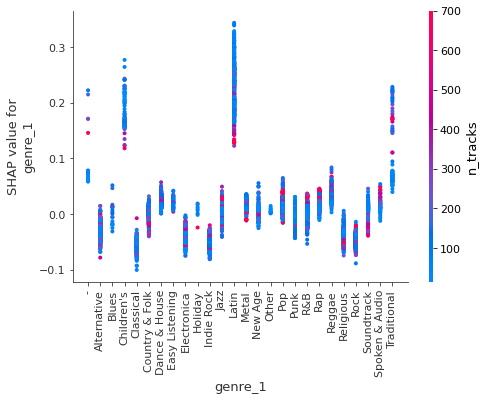

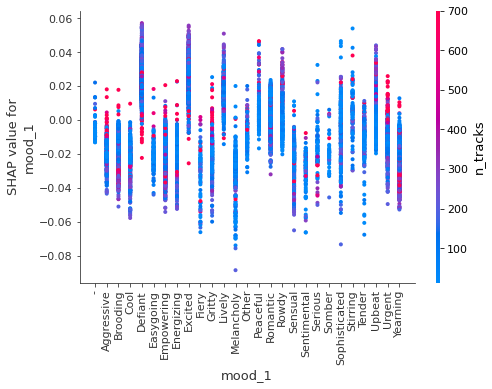

In [35]:
create_model_explanations(mod = users_today_nonspotify_mod,
                          X = X_nonspotify)

# Modeling Results for Number of Users in Current and Previous Month Amongst User-Owned Playlists

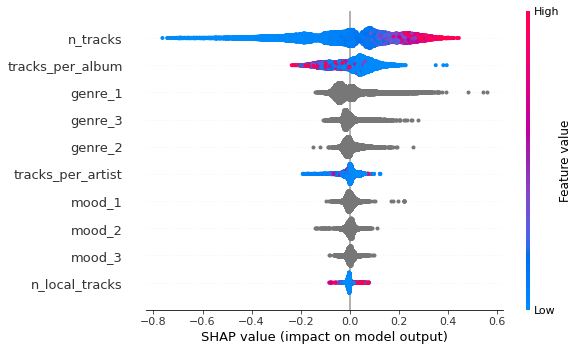

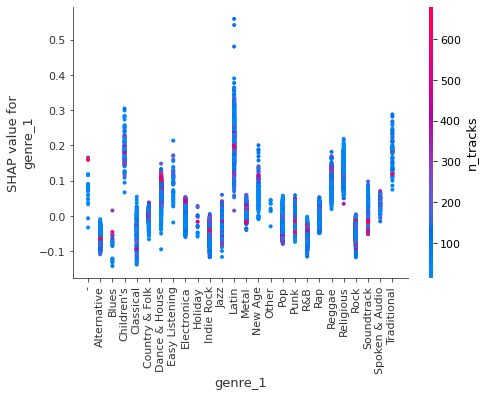

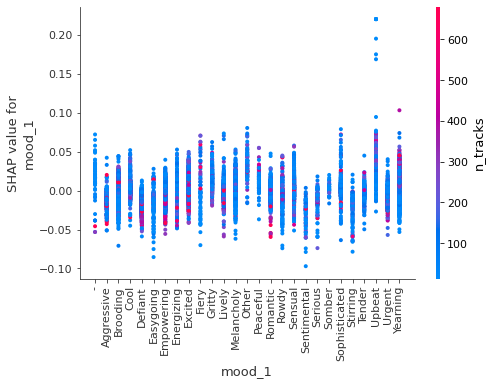

In [36]:
create_model_explanations(mod = users_bothmonths_nonspotify_mod,
                          X = X_nonspotify)

In [37]:
#shap.initjs()
# shap.force_plot(base_value = explainer.expected_value,
#                shap_values = shap_values,
#                features = X_reduced)

In [38]:
#shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

# Appendix

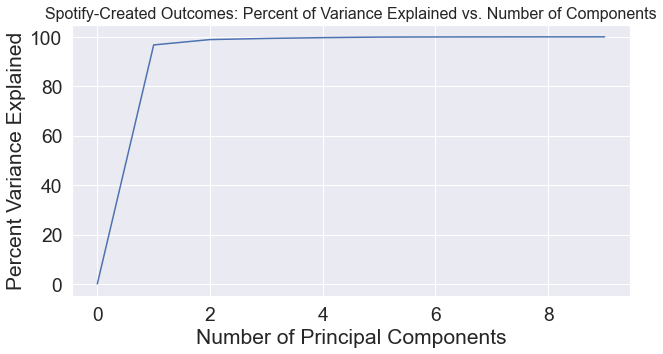

In [190]:
 plot_percent_variation_explained(
     spotify_outcome_scaled,
     title = 'Spotify-Created Outcomes: Percent of Variance Explained vs. Number of Components'
 )

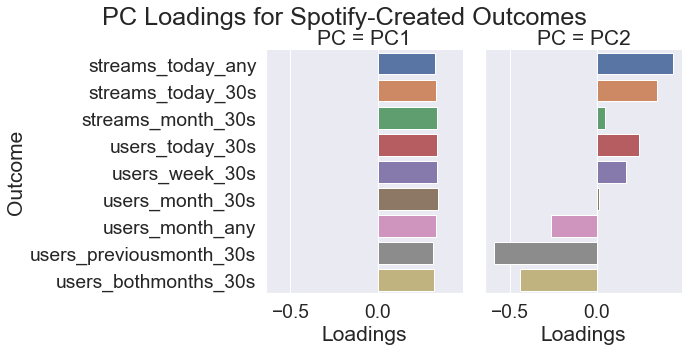

In [177]:
plot_pca_loadings(spotify_outcome_data,
                 title = 'PC Loadings for Spotify-Created Outcomes')